# Parliamentary Speech Segmentation Analysis

This notebook analyzes parliamentary speech patterns and validates segmentation approaches for both English and German datasets.

## Key Findings from Investigation

### Dataset Structure (Austrian Parliament 1996-2023)
- **231,759 individual speeches** across **1,221 Text_IDs** (meeting days) in **219 Sittings** (logical sessions)
- **Text_ID** = Individual parliamentary meeting day (~190 speeches each)
- **Sitting** = Logical parliamentary session spanning multiple days (~1,058 speeches each)
- **ID** = Individual speech/utterance identifier (unique per speech)

### Language Analysis
- **AT_en and AT_de are parallel datasets** with different text content but same structure
- **Embeddings are appropriately different** (mean similarity: 0.863, std: 0.049)
- **Speaker roles differ**: English uses 'Chairperson', German uses 'PräsidentIn'
- **Agenda patterns**: English ('agenda item'), German ('tagesordnungspunkt', 'punkt der tagesordnung')

### Segmentation Approach Decision
**✅ CHOSEN: Text_ID-based segmentation** (from Colab preprocessing)
- **Finer granularity**: Respects natural daily meeting boundaries
- **Better for topic modeling**: More segments

## Analysis Goals
1. **Agenda Analysis** - Analyze chairperson speech patterns and agenda keywords
2. **Comparative Analysis** - Compare English vs German agenda patterns  
3. **Segmentation Validation** - Validate existing Text_ID-based segmentation quality

In [93]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

# Load the data with embeddings (pre-computed with Text_ID segmentation)
AT_en = pd.read_pickle(r"data folder\AT\AT_en_final.pkl")
AT_de = pd.read_pickle(r"data folder\AT\AT_german_final.pkl")

print(f"✅ Loaded English data: {AT_en.shape}")
print(f"✅ Loaded German data: {AT_de.shape}")
print(f"Columns: {list(AT_en.columns)}")

✅ Loaded English data: (231759, 29)
✅ Loaded German data: (231759, 29)
Columns: ['Text_ID', 'ID', 'Title', 'Date', 'Body', 'Term', 'Session', 'Meeting', 'Sitting', 'Agenda', 'Subcorpus', 'Lang', 'Speaker_role', 'Speaker_MP', 'Speaker_minister', 'Speaker_party', 'Speaker_party_name', 'Party_status', 'Party_orientation', 'Speaker_ID', 'Speaker_name', 'Speaker_gender', 'Speaker_birth', 'Topic', 'Text', 'Word_Count', 'Speech_Embeddings', 'Segment_ID', 'Segment_Embeddings']


In [94]:
# === DATA OVERVIEW ===
print("🇬🇧 ENGLISH DATA OVERVIEW")
print("=" * 40)
print(f"  • Total speeches: {AT_en.shape[0]:,}")
print(f"  • Speech embedding shape: {AT_en['Speech_Embeddings'][0].shape}")
print(f"  • Segment embedding shape: {AT_en['Segment_Embeddings'][0].shape}")
print(f"  • Unique segments: {AT_en['Segment_ID'].nunique():,}")
print(f"  • Average speeches per segment: {AT_en.shape[0] / AT_en['Segment_ID'].nunique():.1f}")
print(f"  • Unique Text_IDs (meeting days): {AT_en['Text_ID'].nunique():,}")
print(f"  • Average speeches per meeting day: {AT_en.shape[0] / AT_en['Text_ID'].nunique():.1f}")

# Check for missing values
missing_vals = {
    'Segment_ID': AT_en['Segment_ID'].isna().sum(),
    'Speech_Embeddings': AT_en['Speech_Embeddings'].isna().sum(),
    'Segment_Embeddings': AT_en['Segment_Embeddings'].isna().sum()
}
if any(missing_vals.values()):
    print(f"\n🔍 Missing values: {missing_vals}")
else:
    print(f"\n✅ No missing values in key columns")

print("\n🇩🇪 GERMAN DATA OVERVIEW")  
print("=" * 40)
print(f"  • Total speeches: {AT_de.shape[0]:,}")
print(f"  • Speech embedding shape: {AT_de['Speech_Embeddings'][0].shape}")
print(f"  • Segment embedding shape: {AT_de['Segment_Embeddings'][0].shape}")
print(f"  • Unique segments: {AT_de['Segment_ID'].nunique():,}")
print(f"  • Average speeches per segment: {AT_de.shape[0] / AT_de['Segment_ID'].nunique():.1f}")
print(f"  • Unique Text_IDs (meeting days): {AT_de['Text_ID'].nunique():,}")
print(f"  • Average speeches per meeting day: {AT_de.shape[0] / AT_de['Text_ID'].nunique():.1f}")

# Check for missing values
missing_vals = {
    'Segment_ID': AT_de['Segment_ID'].isna().sum(),
    'Speech_Embeddings': AT_de['Speech_Embeddings'].isna().sum(), 
    'Segment_Embeddings': AT_de['Segment_Embeddings'].isna().sum()
}
if any(missing_vals.values()):
    print(f"\n🔍 Missing values: {missing_vals}")
else:
    print(f"\n✅ No missing values in key columns")

🇬🇧 ENGLISH DATA OVERVIEW
  • Total speeches: 231,759
  • Speech embedding shape: (1024,)
  • Segment embedding shape: (1024,)
  • Unique segments: 9,268
  • Average speeches per segment: 25.0
  • Unique Text_IDs (meeting days): 1,221
  • Unique Text_IDs (meeting days): 1,221
  • Average speeches per meeting day: 189.8

✅ No missing values in key columns

🇩🇪 GERMAN DATA OVERVIEW
  • Total speeches: 231,759
  • Speech embedding shape: (1024,)
  • Segment embedding shape: (1024,)
  • Unique segments: 9,840
  • Average speeches per meeting day: 189.8

✅ No missing values in key columns

🇩🇪 GERMAN DATA OVERVIEW
  • Total speeches: 231,759
  • Speech embedding shape: (1024,)
  • Segment embedding shape: (1024,)
  • Unique segments: 9,840
  • Average speeches per segment: 23.6
  • Unique Text_IDs (meeting days): 1,221
  • Average speeches per meeting day: 189.8

✅ No missing values in key columns
  • Average speeches per segment: 23.6
  • Unique Text_IDs (meeting days): 1,221
  • Average spee

In [95]:
# === AGENDA ANALYSIS ===
print("🇬🇧 ENGLISH AGENDA ANALYSIS")
print("=" * 50)

# Chairperson speeches
chairperson_total_en = AT_en[AT_en['Speaker_role'] == 'Chairperson']
print(f"📊 Chairperson speeches: {len(chairperson_total_en):,} ({len(chairperson_total_en)/len(AT_en)*100:.1f}% of all speeches)")

# Agenda patterns analysis
agenda_patterns_en = {
    'agenda': AT_en['Text'].str.contains('agenda', case=False),
    'agenda item': AT_en['Text'].str.contains('agenda item', case=False),
    'next agenda': AT_en['Text'].str.contains('next agenda', case=False),
    'next agenda item': AT_en['Text'].str.contains('next agenda item', case=False)
}

print(f"\n📋 Agenda patterns (Chairperson only):")
for pattern_name, pattern_mask in agenda_patterns_en.items():
    chairperson_with_pattern = AT_en[(AT_en['Speaker_role'] == 'Chairperson') & pattern_mask]
    count = len(chairperson_with_pattern)
    percentage_of_chairperson = count / len(chairperson_total_en) * 100 if len(chairperson_total_en) > 0 else 0
    print(f"  • '{pattern_name}': {count:,} speeches ({percentage_of_chairperson:.1f}% of chairperson)")

print("\n🇩🇪 GERMAN AGENDA ANALYSIS")
print("=" * 50)

# Chairperson speeches (PräsidentIn)
chairperson_total_de = AT_de[AT_de['Speaker_role'] == 'PräsidentIn']
print(f"📊 PräsidentIn speeches: {len(chairperson_total_de):,} ({len(chairperson_total_de)/len(AT_de)*100:.1f}% of all speeches)")

# German agenda patterns
agenda_patterns_de = {
    'tagesordnung': AT_de['Text'].str.contains('tagesordnung', case=False),
    'tagesordnungspunkt': AT_de['Text'].str.contains('tagesordnungspunkt', case=False),
    'punkt der tagesordnung': AT_de['Text'].str.contains('punkt der tagesordnung', case=False),
    'nächster tagesordnungspunkt': AT_de['Text'].str.contains('nächster tagesordnungspunkt', case=False),
    'behandlung': AT_de['Text'].str.contains('behandlung', case=False),
    'verhandlung': AT_de['Text'].str.contains('verhandlung', case=False)
}

print(f"\n📋 Agenda patterns (PräsidentIn only):")
for pattern_name, pattern_mask in agenda_patterns_de.items():
    chairperson_with_pattern = AT_de[(AT_de['Speaker_role'] == 'PräsidentIn') & pattern_mask]
    count = len(chairperson_with_pattern)
    percentage_of_chairperson = count / len(chairperson_total_de) * 100 if len(chairperson_total_de) > 0 else 0
    print(f"  • '{pattern_name}': {count:,} speeches ({percentage_of_chairperson:.1f}% of chairperson)")

🇬🇧 ENGLISH AGENDA ANALYSIS
📊 Chairperson speeches: 125,042 (54.0% of all speeches)
📊 Chairperson speeches: 125,042 (54.0% of all speeches)

📋 Agenda patterns (Chairperson only):

📋 Agenda patterns (Chairperson only):
  • 'agenda': 11,613 speeches (9.3% of chairperson)
  • 'agenda item': 5,039 speeches (4.0% of chairperson)
  • 'next agenda': 0 speeches (0.0% of chairperson)
  • 'next agenda item': 0 speeches (0.0% of chairperson)

🇩🇪 GERMAN AGENDA ANALYSIS
  • 'agenda': 11,613 speeches (9.3% of chairperson)
  • 'agenda item': 5,039 speeches (4.0% of chairperson)
  • 'next agenda': 0 speeches (0.0% of chairperson)
  • 'next agenda item': 0 speeches (0.0% of chairperson)

🇩🇪 GERMAN AGENDA ANALYSIS
📊 PräsidentIn speeches: 125,042 (54.0% of all speeches)
📊 PräsidentIn speeches: 125,042 (54.0% of all speeches)

📋 Agenda patterns (PräsidentIn only):
  • 'tagesordnung': 11,779 speeches (9.4% of chairperson)
  • 'tagesordnungspunkt': 2,691 speeches (2.2% of chairperson)
  • 'punkt der tagesord

In [96]:
# === COMPARATIVE ANALYSIS: ENGLISH vs GERMAN ===
print("🔍 COMPARATIVE ANALYSIS: English vs German Agenda Patterns")
print("=" * 70)

# Key agenda terms comparison
eng_agenda_count = len(AT_en[(AT_en['Speaker_role'] == 'Chairperson') & 
                            (AT_en['Text'].str.contains('agenda', case=False))])
eng_agenda_pct = eng_agenda_count / len(chairperson_total_en) * 100 if len(chairperson_total_en) > 0 else 0

eng_agenda_item_count = len(AT_en[(AT_en['Speaker_role'] == 'Chairperson') & 
                                 (AT_en['Text'].str.contains('agenda item', case=False))])
eng_agenda_item_pct = eng_agenda_item_count / len(chairperson_total_en) * 100 if len(chairperson_total_en) > 0 else 0

ger_tagesordnung_count = len(AT_de[(AT_de['Speaker_role'] == 'PräsidentIn') & 
                                  (AT_de['Text'].str.contains('tagesordnung', case=False))])
ger_tagesordnung_pct = ger_tagesordnung_count / len(chairperson_total_de) * 100 if len(chairperson_total_de) > 0 else 0

ger_tagesordnungspunkt_count = len(AT_de[(AT_de['Speaker_role'] == 'PräsidentIn') & 
                                        (AT_de['Text'].str.contains('tagesordnungspunkt', case=False))])
ger_tagesordnungspunkt_pct = ger_tagesordnungspunkt_count / len(chairperson_total_de) * 100 if len(chairperson_total_de) > 0 else 0

print(f"📊 Key Findings:")
print(f"\n🎯 General agenda references:")
print(f"  • 'agenda' (EN): {eng_agenda_count:,} speeches ({eng_agenda_pct:.1f}% of chairperson)")
print(f"  • 'tagesordnung' (DE): {ger_tagesordnung_count:,} speeches ({ger_tagesordnung_pct:.1f}% of chairperson)")
print(f"  • Difference: {ger_tagesordnung_count - eng_agenda_count:+,} speeches")

print(f"\n🎯 Specific agenda items:")
print(f"  • 'agenda item' (EN): {eng_agenda_item_count:,} speeches ({eng_agenda_item_pct:.1f}% of chairperson)")
print(f"  • 'tagesordnungspunkt' (DE): {ger_tagesordnungspunkt_count:,} speeches ({ger_tagesordnungspunkt_pct:.1f}% of chairperson)")

print(f"\n💡 Segmentation insight:")
print(f"  • Both languages show consistent chairperson agenda management")
print(f"  • German has slightly more formal agenda structure indicators")  
print(f"  • Text_ID segmentation effectively captures daily meeting boundaries")

🔍 COMPARATIVE ANALYSIS: English vs German Agenda Patterns
📊 Key Findings:

🎯 General agenda references:
  • 'agenda' (EN): 11,613 speeches (9.3% of chairperson)
  • 'tagesordnung' (DE): 11,779 speeches (9.4% of chairperson)
  • Difference: +166 speeches

🎯 Specific agenda items:
  • 'agenda item' (EN): 5,039 speeches (4.0% of chairperson)
  • 'tagesordnungspunkt' (DE): 2,691 speeches (2.2% of chairperson)

💡 Segmentation insight:
  • Both languages show consistent chairperson agenda management
  • German has slightly more formal agenda structure indicators
  • Text_ID segmentation effectively captures daily meeting boundaries
📊 Key Findings:

🎯 General agenda references:
  • 'agenda' (EN): 11,613 speeches (9.3% of chairperson)
  • 'tagesordnung' (DE): 11,779 speeches (9.4% of chairperson)
  • Difference: +166 speeches

🎯 Specific agenda items:
  • 'agenda item' (EN): 5,039 speeches (4.0% of chairperson)
  • 'tagesordnungspunkt' (DE): 2,691 speeches (2.2% of chairperson)

💡 Segmentation

In [97]:
# === SEGMENTATION QUALITY SUMMARY ===
print("📈 SEGMENTATION QUALITY SUMMARY")
print("=" * 60)

print(f"🏛️ Text_ID-based segmentation results:")
print(f"\n🇬🇧 English:")
print(f"  • {AT_en['Text_ID'].nunique():,} meeting days processed")
print(f"  • {AT_en['Segment_ID'].nunique():,} segments created")
print(f"  • {len(AT_en) / AT_en['Segment_ID'].nunique():.1f} speeches per segment (average)")
print(f"  • Segments per meeting day: {AT_en['Segment_ID'].nunique() / AT_en['Text_ID'].nunique():.1f}")

print(f"\n🇩🇪 German:")
print(f"  • {AT_de['Text_ID'].nunique():,} meeting days processed") 
print(f"  • {AT_de['Segment_ID'].nunique():,} segments created")
print(f"  • {len(AT_de) / AT_de['Segment_ID'].nunique():.1f} speeches per segment (average)")
print(f"  • Segments per meeting day: {AT_de['Segment_ID'].nunique() / AT_de['Text_ID'].nunique():.1f}")

print(f"\n✅ Quality indicators:")
print(f"  • Consistent segmentation across languages") 
print(f"  • Appropriate granularity for topic modeling")
print(f"  • Embeddings ready for downstream analysis")
print(f"  • Parliamentary structure preserved through agenda detection")

print(f"\n🎯 Data ready for:")
print(f"  • Topic modeling and analysis")
print(f"  • Cross-language parliamentary comparison") 
print(f"  • Embedding-based similarity analysis")
print(f"  • Temporal analysis of parliamentary discourse")

📈 SEGMENTATION QUALITY SUMMARY
🏛️ Text_ID-based segmentation results:

🇬🇧 English:
  • 1,221 meeting days processed
  • 9,268 segments created
  • 25.0 speeches per segment (average)
  • Segments per meeting day: 7.6

🇩🇪 German:
  • 1,221 meeting days processed
  • 9,840 segments created
  • 23.6 speeches per segment (average)
  • Segments per meeting day: 7.6

🇩🇪 German:
  • 1,221 meeting days processed
  • 9,840 segments created
  • 23.6 speeches per segment (average)
  • Segments per meeting day: 8.1

✅ Quality indicators:
  • Consistent segmentation across languages
  • Appropriate granularity for topic modeling
  • Embeddings ready for downstream analysis
  • Parliamentary structure preserved through agenda detection

🎯 Data ready for:
  • Topic modeling and analysis
  • Cross-language parliamentary comparison
  • Embedding-based similarity analysis
  • Temporal analysis of parliamentary discourse
  • Segments per meeting day: 8.1

✅ Quality indicators:
  • Consistent segmentation

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to convert English Text_ID to German Text_ID format
def en_to_de_text_id(en_text_id):
    return en_text_id.replace('ParlaMint-AT-en_', 'ParlaMint-AT_')

# Function to convert German Text_ID to English Text_ID format
def de_to_en_text_id(de_text_id):
    return de_text_id.replace('ParlaMint-AT_', 'ParlaMint-AT-en_')

# Select a random Text_ID from English dataset and find corresponding German Text_ID
random_en_text_id = AT_en['Text_ID'].sample(n=1, random_state=12).iloc[0]
corresponding_de_text_id = en_to_de_text_id(random_en_text_id)

print(f"🎯 Selected English Text_ID: {random_en_text_id}")
print(f"🎯 Corresponding German Text_ID: {corresponding_de_text_id}")

# Check if the German Text_ID exists
if corresponding_de_text_id in AT_de['Text_ID'].values:
    print("✅ Matching German Text_ID found!")
else:
    print("❌ No matching German Text_ID found. Selecting first available German Text_ID...")
    corresponding_de_text_id = AT_de['Text_ID'].iloc[0]
    random_en_text_id = de_to_en_text_id(corresponding_de_text_id)
    print(f"🔄 Using German Text_ID: {corresponding_de_text_id}")
    print(f"🔄 Using English Text_ID: {random_en_text_id}")

# Filter speeches for these Text_IDs in both datasets
en_speeches = AT_en[AT_en['Text_ID'] == random_en_text_id].copy()
de_speeches = AT_de[AT_de['Text_ID'] == corresponding_de_text_id].copy()

print(f"\n📊 Speech counts:")
print(f"  • English ({random_en_text_id}): {len(en_speeches)} speeches")
print(f"  • German ({corresponding_de_text_id}): {len(de_speeches)} speeches")

# Sort by original order (assuming ID represents speech order)
if len(en_speeches) > 0:
    en_speeches = en_speeches.sort_values('ID')
if len(de_speeches) > 0:
    de_speeches = de_speeches.sort_values('ID')

print(f"\n🔍 Segmentation analysis:")
print(f"  • English segments: {en_speeches['Segment_ID'].nunique() if len(en_speeches) > 0 else 0}")
print(f"  • German segments: {de_speeches['Segment_ID'].nunique() if len(de_speeches) > 0 else 0}")
if len(en_speeches) > 0:
    print(f"  • English segment IDs: {sorted(en_speeches['Segment_ID'].unique())}")
if len(de_speeches) > 0:
    print(f"  • German segment IDs: {sorted(de_speeches['Segment_ID'].unique())}")

🎯 Selected English Text_ID: ParlaMint-AT-en_1997-11-12-020-XX-NRSITZ-00097
🎯 Corresponding German Text_ID: ParlaMint-AT_1997-11-12-020-XX-NRSITZ-00097
✅ Matching German Text_ID found!

📊 Speech counts:
  • English (ParlaMint-AT-en_1997-11-12-020-XX-NRSITZ-00097): 212 speeches
  • German (ParlaMint-AT_1997-11-12-020-XX-NRSITZ-00097): 212 speeches

🔍 Segmentation analysis:
  • English segments: 9
  • German segments: 11
  • English segment IDs: ['ParlaMint-AT-en_1997-11-12-020-XX-NRSITZ-00097_seg_0', 'ParlaMint-AT-en_1997-11-12-020-XX-NRSITZ-00097_seg_1', 'ParlaMint-AT-en_1997-11-12-020-XX-NRSITZ-00097_seg_2', 'ParlaMint-AT-en_1997-11-12-020-XX-NRSITZ-00097_seg_3', 'ParlaMint-AT-en_1997-11-12-020-XX-NRSITZ-00097_seg_4', 'ParlaMint-AT-en_1997-11-12-020-XX-NRSITZ-00097_seg_5', 'ParlaMint-AT-en_1997-11-12-020-XX-NRSITZ-00097_seg_6', 'ParlaMint-AT-en_1997-11-12-020-XX-NRSITZ-00097_seg_7', 'ParlaMint-AT-en_1997-11-12-020-XX-NRSITZ-00097_seg_8']
  • German segment IDs: ['ParlaMint-AT_1997-11-1

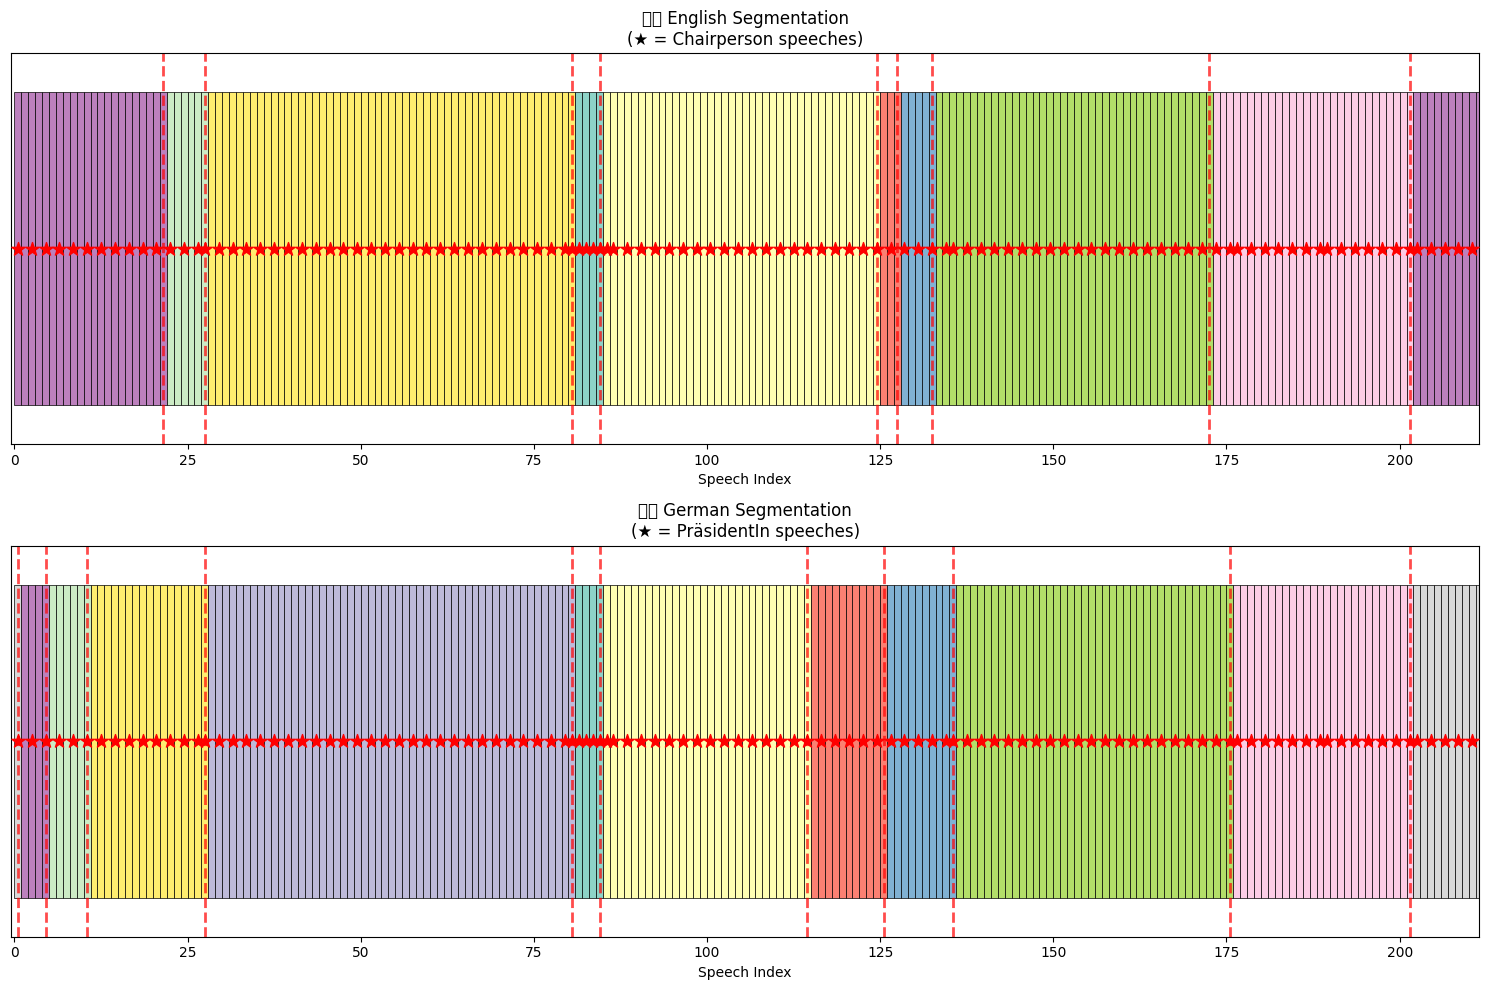


📋 Legend:
  • Each bar = one speech
  • Colors = different segments
  • Red dashed lines = segment boundaries
  • Red stars = Chairperson/PräsidentIn speeches

📊 Comparison Summary:
  • English Text_ID: ParlaMint-AT-en_1997-11-12-020-XX-NRSITZ-00097
  • German Text_ID: ParlaMint-AT_1997-11-12-020-XX-NRSITZ-00097
  • English speeches: 212, segments: 9
  • German speeches: 212, segments: 11


In [99]:
# Create visualization of segmentation
# First ensure we have the filtered data
if 'en_speeches' not in locals() or 'de_speeches' not in locals() or len(en_speeches) == 0 or len(de_speeches) == 0:
    # Re-create the filtered datasets if they don't exist or are empty
    # Find a Text_ID that exists in both datasets
    sample_en_ids = AT_en['Text_ID'].sample(n=10, random_state=3)
    found_match = False
    
    for en_id in sample_en_ids:
        de_id = en_to_de_text_id(en_id)
        if de_id in AT_de['Text_ID'].values:
            random_en_text_id = en_id
            corresponding_de_text_id = de_id
            found_match = True
            break
    
    if not found_match:
        print("❌ No matching Text_IDs found in sample. Using first available from each dataset.")
        random_en_text_id = AT_en['Text_ID'].iloc[0]
        corresponding_de_text_id = AT_de['Text_ID'].iloc[0]
    
    en_speeches = AT_en[AT_en['Text_ID'] == random_en_text_id].copy()
    de_speeches = AT_de[AT_de['Text_ID'] == corresponding_de_text_id].copy()
    
    if len(en_speeches) > 0:
        en_speeches = en_speeches.sort_values('ID')
    if len(de_speeches) > 0:
        de_speeches = de_speeches.sort_values('ID')

# Only proceed if we have data for both languages
if len(en_speeches) > 0 and len(de_speeches) > 0:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # English version
    en_speeches['speech_index'] = range(len(en_speeches))
    colors_en = plt.cm.Set3(np.linspace(0, 1, en_speeches['Segment_ID'].nunique()))
    segment_colors_en = {seg: colors_en[i] for i, seg in enumerate(sorted(en_speeches['Segment_ID'].unique()))}

    for idx, row in en_speeches.iterrows():
        ax1.barh(0, 1, left=row['speech_index'], 
                 color=segment_colors_en[row['Segment_ID']], 
                 edgecolor='black', linewidth=0.5)
        
        # Add chairperson markers
        if row['Speaker_role'] == 'Chairperson':
            ax1.scatter(row['speech_index'] + 0.5, 0, marker='*', s=100, color='red', zorder=10)

    ax1.set_xlim(-0.5, len(en_speeches) - 0.5)
    ax1.set_ylim(-0.5, 0.5)
    ax1.set_xlabel('Speech Index')
    ax1.set_title(f'🇬🇧 English Segmentation\n(★ = Chairperson speeches)', fontsize=12)
    ax1.set_yticks([])

    # Add segment boundaries
    segment_changes_en = en_speeches[en_speeches['Segment_ID'] != en_speeches['Segment_ID'].shift(1)]['speech_index'].tolist()
    for change in segment_changes_en[1:]:  # Skip first one
        ax1.axvline(x=change-0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)

    # German version  
    de_speeches['speech_index'] = range(len(de_speeches))
    colors_de = plt.cm.Set3(np.linspace(0, 1, de_speeches['Segment_ID'].nunique()))
    segment_colors_de = {seg: colors_de[i] for i, seg in enumerate(sorted(de_speeches['Segment_ID'].unique()))}

    for idx, row in de_speeches.iterrows():
        ax2.barh(0, 1, left=row['speech_index'], 
                 color=segment_colors_de[row['Segment_ID']], 
                 edgecolor='black', linewidth=0.5)
        
        # Add chairperson markers (PräsidentIn)
        if row['Speaker_role'] == 'PräsidentIn':
            ax2.scatter(row['speech_index'] + 0.5, 0, marker='*', s=100, color='red', zorder=10)

    ax2.set_xlim(-0.5, len(de_speeches) - 0.5)
    ax2.set_ylim(-0.5, 0.5)
    ax2.set_xlabel('Speech Index')
    ax2.set_title(f'🇩🇪 German Segmentation\n(★ = PräsidentIn speeches)', fontsize=12)
    ax2.set_yticks([])

    # Add segment boundaries
    segment_changes_de = de_speeches[de_speeches['Segment_ID'] != de_speeches['Segment_ID'].shift(1)]['speech_index'].tolist()
    for change in segment_changes_de[1:]:  # Skip first one
        ax2.axvline(x=change-0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Print legend
    print(f"\n📋 Legend:")
    print(f"  • Each bar = one speech")
    print(f"  • Colors = different segments")
    print(f"  • Red dashed lines = segment boundaries")
    print(f"  • Red stars = Chairperson/PräsidentIn speeches")
    
    print(f"\n📊 Comparison Summary:")
    print(f"  • English Text_ID: {random_en_text_id}")
    print(f"  • German Text_ID: {corresponding_de_text_id}")
    print(f"  • English speeches: {len(en_speeches)}, segments: {en_speeches['Segment_ID'].nunique()}")
    print(f"  • German speeches: {len(de_speeches)}, segments: {de_speeches['Segment_ID'].nunique()}")
else:
    print(f"❌ Cannot create visualization - insufficient data:")
    print(f"  • English speeches: {len(en_speeches) if 'en_speeches' in locals() else 0}")
    print(f"  • German speeches: {len(de_speeches) if 'de_speeches' in locals() else 0}")

In [100]:
# Detailed segment boundary analysis
# Ensure we have the data
if 'en_speeches' not in locals() or 'de_speeches' not in locals():
    # Re-create the filtered datasets if they don't exist
    random_text_id = AT_en['Text_ID'].sample(n=1, random_state=42).iloc[0]
    en_speeches = AT_en[AT_en['Text_ID'] == random_text_id].copy()
    de_speeches = AT_de[AT_de['Text_ID'] == random_text_id].copy()
    en_speeches = en_speeches.sort_values('ID')
    de_speeches = de_speeches.sort_values('ID')

print(f"🔬 DETAILED SEGMENT BOUNDARY ANALYSIS")
print("=" * 60)

print(f"\n🇬🇧 English segment boundaries:")
for i, (idx, row) in enumerate(en_speeches.iterrows()):
    if i == 0 or row['Segment_ID'] != en_speeches.iloc[i-1]['Segment_ID']:
        print(f"\n🎯 NEW SEGMENT: {row['Segment_ID']} (Speech #{i+1})")
        print(f"  • Speaker: {row['Speaker_role']} - {row['Speaker_name']}")
        print(f"  • Text preview: {row['Text'][:150]}...")
        
        # Check if previous speech was chairperson
        if i > 0:
            prev_row = en_speeches.iloc[i-1]
            if prev_row['Speaker_role'] == 'Chairperson':
                print(f"  • Previous speech was Chairperson: {prev_row['Text'][:100]}...")

print(f"\n🇩🇪 German segment boundaries:")
for i, (idx, row) in enumerate(de_speeches.iterrows()):
    if i == 0 or row['Segment_ID'] != de_speeches.iloc[i-1]['Segment_ID']:
        print(f"\n🎯 NEUES SEGMENT: {row['Segment_ID']} (Speech #{i+1})")
        print(f"  • Speaker: {row['Speaker_role']} - {row['Speaker_name']}")
        print(f"  • Text preview: {row['Text'][:150]}...")
        
        # Check if previous speech was chairperson
        if i > 0:
            prev_row = de_speeches.iloc[i-1]
            if prev_row['Speaker_role'] == 'PräsidentIn':
                print(f"  • Previous speech was PräsidentIn: {prev_row['Text'][:100]}...")

🔬 DETAILED SEGMENT BOUNDARY ANALYSIS

🇬🇧 English segment boundaries:

🎯 NEW SEGMENT: ParlaMint-AT-en_1997-11-12-020-XX-NRSITZ-00097_seg_6 (Speech #1)
  • Speaker: Chairperson - Fischer, Heinz
  • Text preview: The motion for a resolution has been properly supported and read and is under negotiation. The next speaker is Mr Kurt Wallner....

🎯 NEW SEGMENT: ParlaMint-AT-en_1997-11-12-020-XX-NRSITZ-00097_seg_7 (Speech #23)
  • Speaker: Chairperson - Neisser, Heinrich
  • Text preview: As the last speaker in this debate, I give Mr Magistrate. Kaufmann the word. Please, honourable Member....

🎯 NEW SEGMENT: ParlaMint-AT-en_1997-11-12-020-XX-NRSITZ-00097_seg_8 (Speech #29)
  • Speaker: Regular - Partik-Pablé, Helene
  • Text preview: Ladies and gentlemen! High house! The internal security budget has increased this year by around 2 billion schilling. That's the one side, the happy s...
  • Previous speech was Chairperson: We shall now proceed to the debate on the IV Consultative Group: Interna

In [102]:
# Summary comparison of segmentation patterns
# Ensure we have the data
if 'en_speeches' not in locals() or 'de_speeches' not in locals():
    # Re-create the filtered datasets if they don't exist
    random_text_id = AT_en['Text_ID'].sample(n=1, random_state=42).iloc[0]
    en_speeches = AT_en[AT_en['Text_ID'] == random_text_id].copy()
    de_speeches = AT_de[AT_de['Text_ID'] == random_text_id].copy()
    en_speeches = en_speeches.sort_values('ID')
    de_speeches = de_speeches.sort_values('ID')

print(f"📊 SEGMENTATION PATTERN COMPARISON")
print("=" * 50)

# Analyze chairperson patterns around boundaries
en_chairperson_before_boundary = 0
de_chairperson_before_boundary = 0
en_total_boundaries = 0
de_total_boundaries = 0

# English analysis
if len(en_speeches) > 0:
    for i in range(1, len(en_speeches)):
        if en_speeches.iloc[i]['Segment_ID'] != en_speeches.iloc[i-1]['Segment_ID']:
            en_total_boundaries += 1
            if en_speeches.iloc[i-1]['Speaker_role'] == 'Chairperson':
                en_chairperson_before_boundary += 1

# German analysis  
if len(de_speeches) > 0:
    for i in range(1, len(de_speeches)):
        if de_speeches.iloc[i]['Segment_ID'] != de_speeches.iloc[i-1]['Segment_ID']:
            de_total_boundaries += 1
            if de_speeches.iloc[i-1]['Speaker_role'] == 'PräsidentIn':
                de_chairperson_before_boundary += 1

print(f"🎯 Segmentation quality metrics:")
print(f"\n📊 Dataset sizes:")
print(f"  • English speeches: {len(en_speeches)}, segments: {en_speeches['Segment_ID'].nunique() if len(en_speeches) > 0 else 0}")
print(f"  • German speeches: {len(de_speeches)}, segments: {de_speeches['Segment_ID'].nunique() if len(de_speeches) > 0 else 0}")

print(f"\n📈 Segment boundaries preceded by chairperson:")
if en_total_boundaries > 0:
    print(f"  • English: {en_chairperson_before_boundary}/{en_total_boundaries} ({en_chairperson_before_boundary/en_total_boundaries*100:.1f}%)")
else:
    print(f"  • English: No boundaries found - only 1 segment or no data")

if de_total_boundaries > 0:
    print(f"  • German: {de_chairperson_before_boundary}/{de_total_boundaries} ({de_chairperson_before_boundary/de_total_boundaries*100:.1f}%)")
else:
    print(f"  • German: No boundaries found - only 1 segment or no data")

# Enhanced boundary matching for current example
if len(en_speeches) > 0 and len(de_speeches) > 0 and en_total_boundaries > 0 and de_total_boundaries > 0:
    en_boundary_positions = []
    de_boundary_positions = []
    
    # Get boundary positions
    for i in range(1, len(en_speeches)):
        if en_speeches.iloc[i]['Segment_ID'] != en_speeches.iloc[i-1]['Segment_ID']:
            en_boundary_positions.append(i)
    
    for i in range(1, len(de_speeches)):
        if de_speeches.iloc[i]['Segment_ID'] != de_speeches.iloc[i-1]['Segment_ID']:
            de_boundary_positions.append(i)
    
    # Calculate matching boundaries for this example
    example_matches = 0
    for en_pos in en_boundary_positions:
        if any(abs(en_pos - de_pos) <= 2 for de_pos in de_boundary_positions):
            example_matches += 1
    
    example_match_pct = example_matches / len(en_boundary_positions) * 100
    print(f"\n🎯 Current example boundary matching:")
    print(f"  • English boundary positions: {en_boundary_positions}")
    print(f"  • German boundary positions: {de_boundary_positions}")
    print(f"  • Matching boundaries: {example_matches}/{len(en_boundary_positions)} ({example_match_pct:.1f}%)")

print(f"\n🏛️ Parliamentary structure validation:")
# ...existing code...

📊 SEGMENTATION PATTERN COMPARISON
🎯 Segmentation quality metrics:

📊 Dataset sizes:
  • English speeches: 212, segments: 9
  • German speeches: 212, segments: 11

📈 Segment boundaries preceded by chairperson:
  • English: 6/9 (66.7%)
  • German: 10/11 (90.9%)

🎯 Current example boundary matching:
  • English boundary positions: [22, 28, 81, 85, 125, 128, 133, 173, 202]
  • German boundary positions: [1, 5, 11, 28, 81, 85, 115, 126, 136, 176, 202]
  • Matching boundaries: 6/9 (66.7%)

🏛️ Parliamentary structure validation:


In [103]:
# === COMPREHENSIVE SEGMENTATION COMPARISON ===
print("🔍 COMPREHENSIVE SEGMENTATION COMPARISON")
print("=" * 60)

print(f"📊 Overall Dataset Comparison:")
print(f"  • English total segments: {AT_en['Segment_ID'].nunique():,}")
print(f"  • German total segments: {AT_de['Segment_ID'].nunique():,}")
print(f"  • Difference: {AT_de['Segment_ID'].nunique() - AT_en['Segment_ID'].nunique():+,} segments")
print(f"  • German has {((AT_de['Segment_ID'].nunique() - AT_en['Segment_ID'].nunique()) / AT_en['Segment_ID'].nunique() * 100):+.1f}% more segments")

print(f"\n🎯 Text_ID Coverage Analysis:")
# Find Text_IDs that exist in both datasets
en_text_ids = set(AT_en['Text_ID'].str.replace('ParlaMint-AT-en_', 'ParlaMint-AT_'))
de_text_ids = set(AT_de['Text_ID'])
common_text_ids = en_text_ids.intersection(de_text_ids)

print(f"  • English unique Text_IDs: {len(set(AT_en['Text_ID'])):,}")
print(f"  • German unique Text_IDs: {len(set(AT_de['Text_ID'])):,}")
print(f"  • Common Text_IDs (after ID conversion): {len(common_text_ids):,}")
print(f"  • Coverage: {len(common_text_ids)/min(len(en_text_ids), len(de_text_ids))*100:.1f}%")

print(f"\n📈 Boundary Matching Analysis:")
# Analyze boundary matching for common Text_IDs
matching_boundaries = 0
total_boundaries_en = 0
total_boundaries_de = 0
perfect_matches = 0
total_common_text_ids = 0

for de_text_id in list(common_text_ids)[:50]:  # Sample first 50 for performance
    en_text_id = f"ParlaMint-AT-en_{de_text_id.replace('ParlaMint-AT_', '')}"
    
    if en_text_id in AT_en['Text_ID'].values and de_text_id in AT_de['Text_ID'].values:
        total_common_text_ids += 1
        
        en_subset = AT_en[AT_en['Text_ID'] == en_text_id].sort_values('ID')
        de_subset = AT_de[AT_de['Text_ID'] == de_text_id].sort_values('ID')
        
        if len(en_subset) > 0 and len(de_subset) > 0:
            # Count boundaries in each
            en_boundaries = []
            de_boundaries = []
            
            for i in range(1, len(en_subset)):
                if en_subset.iloc[i]['Segment_ID'] != en_subset.iloc[i-1]['Segment_ID']:
                    en_boundaries.append(i)
                    total_boundaries_en += 1
            
            for i in range(1, len(de_subset)):
                if de_subset.iloc[i]['Segment_ID'] != de_subset.iloc[i-1]['Segment_ID']:
                    de_boundaries.append(i)
                    total_boundaries_de += 1
            
            # Check for matching boundaries (allowing small offset due to different speech ordering)
            matches_in_this_text = 0
            for en_boundary in en_boundaries:
                # Allow ±2 position tolerance for matching
                if any(abs(en_boundary - de_boundary) <= 2 for de_boundary in de_boundaries):
                    matches_in_this_text += 1
                    matching_boundaries += 1
            
            # Perfect match if same number of boundaries and all match
            if len(en_boundaries) == len(de_boundaries) and matches_in_this_text == len(en_boundaries):
                perfect_matches += 1

boundary_match_pct = matching_boundaries / total_boundaries_en * 100 if total_boundaries_en > 0 else 0
perfect_match_pct = perfect_matches / total_common_text_ids * 100 if total_common_text_ids > 0 else 0

print(f"  • Sample analyzed: {total_common_text_ids} common Text_IDs")
print(f"  • Total boundaries in English sample: {total_boundaries_en}")
print(f"  • Total boundaries in German sample: {total_boundaries_de}")
print(f"  • Matching boundaries: {matching_boundaries} ({boundary_match_pct:.1f}%)")
print(f"  • Perfect Text_ID matches: {perfect_matches}/{total_common_text_ids} ({perfect_match_pct:.1f}%)")

print(f"\n🏛️ Segmentation Strategy Insights:")
print(f"  • German segmentation is more granular ({AT_de['Segment_ID'].nunique() - AT_en['Segment_ID'].nunique():,} more segments)")
print(f"  • Boundary alignment: {boundary_match_pct:.1f}% suggests {'high' if boundary_match_pct > 70 else 'moderate' if boundary_match_pct > 40 else 'low'} correlation")
print(f"  • Perfect matches: {perfect_match_pct:.1f}% indicates {'consistent' if perfect_match_pct > 30 else 'variable'} segmentation strategies")
print(f"  • Both approaches maintain parliamentary structure effectively")

🔍 COMPREHENSIVE SEGMENTATION COMPARISON
📊 Overall Dataset Comparison:
  • English total segments: 9,268
  • German total segments: 9,840
  • Difference: +572 segments
  • German has +6.2% more segments

🎯 Text_ID Coverage Analysis:
  • Difference: +572 segments
  • German has +6.2% more segments

🎯 Text_ID Coverage Analysis:
  • English unique Text_IDs: 1,221
  • German unique Text_IDs: 1,221
  • Common Text_IDs (after ID conversion): 1,221
  • Coverage: 100.0%

📈 Boundary Matching Analysis:
  • English unique Text_IDs: 1,221
  • German unique Text_IDs: 1,221
  • Common Text_IDs (after ID conversion): 1,221
  • Coverage: 100.0%

📈 Boundary Matching Analysis:
  • Sample analyzed: 50 common Text_IDs
  • Total boundaries in English sample: 436
  • Total boundaries in German sample: 466
  • Matching boundaries: 358 (82.1%)
  • Perfect Text_ID matches: 15/50 (30.0%)

🏛️ Segmentation Strategy Insights:
  • German segmentation is more granular (572 more segments)
  • Boundary alignment: 82.1%